In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import gc
import os
import numpy as np
import plyfile
gc.collect()

0

In [1]:
from aire_scripts.deform_net import DeltaMLP

m = DeltaMLP(aud_in=1707, emo_in=1280).cuda()

c:\Users\arpit\.conda\envs\gaussian_splatting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
param_size = 0
for param in m.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in m.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 6.129MB


#############

In [3]:
import torch
import numpy as np

a = np.zeros((10, 3, 1))
b = np.ones((10, 3, 15))

c = np.hstack((a.reshape(10, -1), b.reshape(10,-1)))
c.shape

(10, 48)

In [6]:
ct = torch.from_numpy(c)
ctr = ct.reshape(10, 3, 16)

In [9]:
ctr[0]

tensor([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       dtype=torch.float64)

####################

In [11]:
import gc
gc.collect()

21

In [2]:
from aire_scripts.deform_dataloader import get_ply_params

xyz, opacities, features, scales, rots = get_ply_params("C:/Users/arpit/Desktop/point_cloud.ply")

In [9]:
features.dtype

dtype('float64')

In [2]:
import numpy
from plyfile import PlyData, PlyElement

with open("C:/Users/arpit/Desktop/point_cloud.ply", 'rb') as f:
    canon_ply = PlyData.read(f)

with open("C:/Users/arpit/Desktop/004_0103.ply", 'rb') as f:
    plydata1 = PlyData.read(f)


In [ ]:
#plydata1.elements[0].properties

In [82]:
gaussian_property = "f_rest_34"

canon_x = canon_ply['vertex'].data[gaussian_property]
canon_x = numpy.vstack(canon_x)

x1 = plydata1['vertex'].data[gaussian_property]
x1 = numpy.vstack(x1)

In [83]:
max(x1 - canon_x), min(x1 - canon_x)

(array([0.29566777], dtype=float32), array([-0.3097363], dtype=float32))

In [84]:
import torch

mse = torch.nn.MSELoss()
mse(torch.from_numpy(x1), torch.from_numpy(canon_x))

tensor(0.0008)

(array([2.000e+00, 3.000e+00, 3.200e+01, 1.670e+02, 1.619e+03, 5.806e+03,
        1.860e+02, 1.900e+01, 2.000e+00, 2.000e+00]),
 array([-0.3097363 , -0.2491959 , -0.1886555 , -0.12811509, -0.06757468,
        -0.00703427,  0.05350614,  0.11404654,  0.17458695,  0.23512736,
         0.29566777], dtype=float32),
 <BarContainer object of 10 artists>)

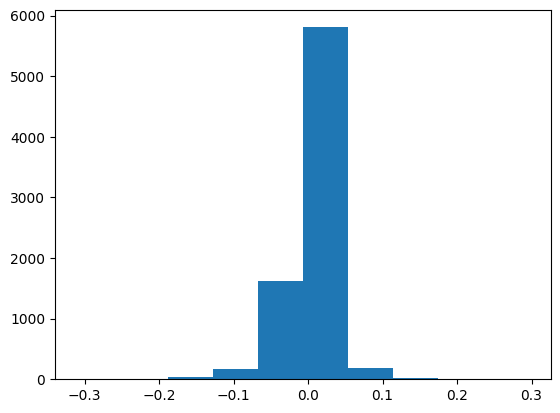

In [85]:
import matplotlib.pyplot as plt

plt.hist(x1 - canon_x)

In [86]:
gc.collect()

21

In [1]:
from aire_scripts.deform_net import DeltaMLP

model = DeltaMLP(aud_in=1707, emo_in=1280).cuda()

In [ ]:
import torch

auds = torch.ones()

### COLMAP Images and Camera BINS

In [1]:
import struct
import numpy as np
import collections

BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])

def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)

def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)


def read_extrinsics_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        image_names = []
        for _ in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))

            image_names.append(image_name)
        
        return image_names 
        #    images[image_id] = Image(
        #        id=image_id, qvec=qvec, tvec=tvec,
        #        camera_id=camera_id, name=image_name,
        #        xys=xys, point3D_ids=point3D_ids)
    #return images


In [8]:
CameraModel = collections.namedtuple(
    "CameraModel", ["model_id", "model_name", "num_params"])
Camera = collections.namedtuple(
    "Camera", ["id", "model", "width", "height", "params"])
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
Point3D = collections.namedtuple(
    "Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"])
CAMERA_MODELS = {
    CameraModel(model_id=0, model_name="SIMPLE_PINHOLE", num_params=3),
    CameraModel(model_id=1, model_name="PINHOLE", num_params=4),
    CameraModel(model_id=2, model_name="SIMPLE_RADIAL", num_params=4),
    CameraModel(model_id=3, model_name="RADIAL", num_params=5),
    CameraModel(model_id=4, model_name="OPENCV", num_params=8),
    CameraModel(model_id=5, model_name="OPENCV_FISHEYE", num_params=8),
    CameraModel(model_id=6, model_name="FULL_OPENCV", num_params=12),
    CameraModel(model_id=7, model_name="FOV", num_params=5),
    CameraModel(model_id=8, model_name="SIMPLE_RADIAL_FISHEYE", num_params=4),
    CameraModel(model_id=9, model_name="RADIAL_FISHEYE", num_params=5),
    CameraModel(model_id=10, model_name="THIN_PRISM_FISHEYE", num_params=12)
}
CAMERA_MODEL_IDS = dict([(camera_model.model_id, camera_model)
                         for camera_model in CAMERA_MODELS])


def read_intrinsics_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::WriteCamerasBinary(const std::string& path)
        void Reconstruction::ReadCamerasBinary(const std::string& path)
    """
    cameras = {}
    with open(path_to_model_file, "rb") as fid:
        num_cameras = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_cameras):
            camera_properties = read_next_bytes(
                fid, num_bytes=24, format_char_sequence="iiQQ")
            camera_id = camera_properties[0]
            model_id = camera_properties[1]
            model_name = CAMERA_MODEL_IDS[camera_properties[1]].model_name
            width = camera_properties[2]
            height = camera_properties[3]
            num_params = CAMERA_MODEL_IDS[model_id].num_params
            params = read_next_bytes(fid, num_bytes=8*num_params,
                                     format_char_sequence="d"*num_params)
            cameras[camera_id] = Camera(id=camera_id,
                                        model=model_name,
                                        width=width,
                                        height=height,
                                        params=np.array(params))
            #return camera_properties, params
        #assert len(cameras) == num_cameras
    return cameras

In [2]:
import os

cameras_extrinsic_file = os.path.join("C:/Users/arpit/Desktop/final/images.bin")
img_names = read_extrinsics_binary(cameras_extrinsic_file)

In [3]:
print(sorted(img_names))

['down_neutral_level_1_015_0001.png', 'down_neutral_level_1_015_0002.png', 'down_neutral_level_1_015_0003.png', 'down_neutral_level_1_015_0004.png', 'down_neutral_level_1_015_0005.png', 'down_neutral_level_1_015_0006.png', 'down_neutral_level_1_015_0007.png', 'down_neutral_level_1_015_0008.png', 'down_neutral_level_1_015_0009.png', 'down_neutral_level_1_015_0010.png', 'down_neutral_level_1_015_0011.png', 'down_neutral_level_1_015_0012.png', 'down_neutral_level_1_015_0013.png', 'down_neutral_level_1_015_0014.png', 'down_neutral_level_1_015_0015.png', 'down_neutral_level_1_015_0016.png', 'down_neutral_level_1_015_0017.png', 'down_neutral_level_1_015_0018.png', 'down_neutral_level_1_015_0019.png', 'down_neutral_level_1_015_0020.png', 'down_neutral_level_1_015_0021.png', 'down_neutral_level_1_015_0022.png', 'down_neutral_level_1_015_0023.png', 'down_neutral_level_1_015_0024.png', 'down_neutral_level_1_015_0025.png', 'down_neutral_level_1_015_0026.png', 'down_neutral_level_1_015_0027.png', 

In [ ]:
qvec, tvec

(array([1.00000000e+00, 1.49332983e-14, 5.56455437e-15, 1.21300557e-16]),
 array([ 5.31875196,  8.74060724, 13.63538993]))

In [9]:
import os

cameras_intrinsic_file = "C:/Users/arpit/Desktop/003/sparse/0/cameras.bin"
cam_intrinsics = read_intrinsics_binary(cameras_intrinsic_file)

In [10]:
cam_intrinsics

{0: Camera(id=0, model='SIMPLE_PINHOLE', width=1920, height=1080, params=array([8564.87695312,  960.        ,  540.        ]))}

In [ ]:
len(cam_intrinsics.keys()), len(cam_extrinsics.keys())

(1, 525)

In [ ]:
len(cam_extrinsics.keys())/7

75.0

In [ ]:
cams = list(range(1, len(cam_extrinsics.keys()), int(len(cam_extrinsics.keys())/7)))
cams

[1, 76, 151, 226, 301, 376, 451]

In [ ]:
cam_extrinsics[cams[0]].name

'down_neutral_002_001.png'

In [1]:
import gc
gc.collect()

145

### Per View Gaussians

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x = np.load("C:/Users/arpit/Desktop/001_0039_20149.npy")
x.shape

(540, 960, 3)

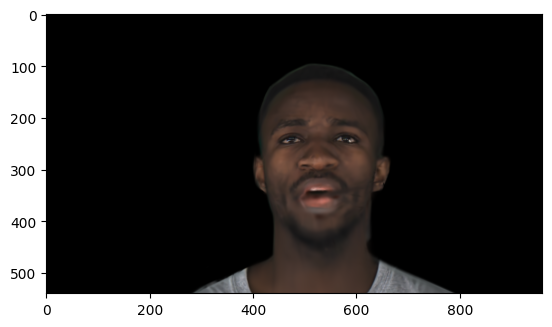

In [3]:
# 110 iters from vanilla 30k

plt.imshow(x)

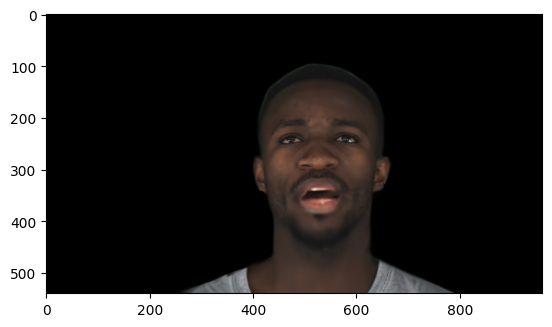

In [5]:
# 120 iters from vanilla 10k

plt.imshow(x)

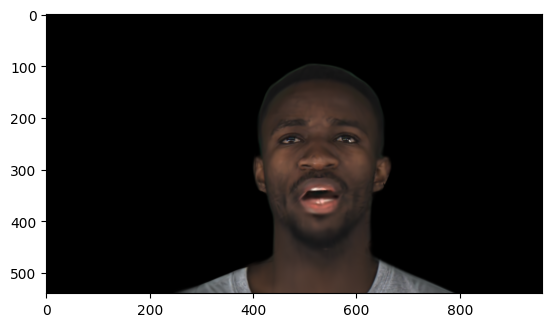

In [7]:
# 130 iters from vanilla 10k

plt.imshow(x)

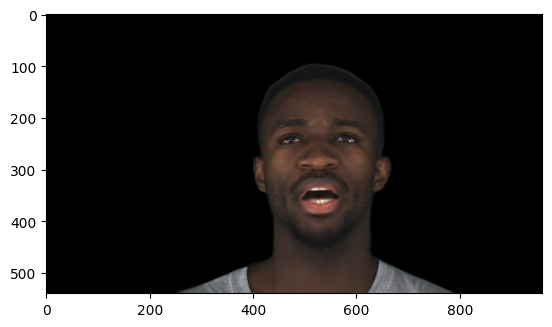

In [14]:
# 150 iters from vanilla 10k

plt.imshow(x)

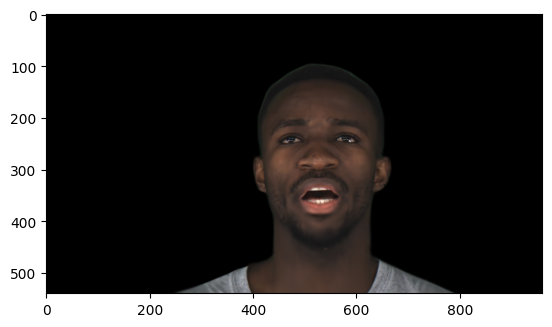

In [12]:
## 200 iters from vanilla 10k

plt.imshow(x)

In [3]:
import gc
gc.collect()

187